In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import json
import os
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler

### Parameters

In [ ]:
# ---- About dataset (no need to change)
#
enhanced_dir     = './data'                  # Enhanced dataset is very small, so ./data in a good choice :-)
run_dir          = 'models'
dataset_filename = 'cleaned-donnees-synop-essentielles-omm(LYS).csv'
schema_filename  = 'new-description-synop-essentielles-omm(LYS).json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- About training (Can be changed !)
#
iterations       = 4        # number of iterations for prediction (1 iteration = 3h)
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .7       # Percentage for train (the rest being for the test)
validation_prop         = 0.15
sequence_len     = 16
batch_size       = 32
epochs           = 10
fit_verbosity    = 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Colab Notebooks/meteo_forecasting(fidle)"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/meteo_forecasting(fidle)


### Dataset

In [ ]:
df = pd.read_csv(f'{enhanced_dir}/{dataset_filename}', header=0, sep=";")

df = df[:int(scale*len(df))]
train_index=int(train_prop*len(df))
validation_index = int(len(df) * (train_prop + validation_prop))

train_set = df.loc[:train_index, features]
validation_set = df.loc[train_index:validation_index, features]
test_set = df.loc[validation_index:, features]

In [ ]:
std_scaler = StandardScaler()

X_train = std_scaler.fit_transform(train_set)
scaled_train_set = pd.DataFrame(X_train, columns=features)

X_val = std_scaler.transform(validation_set)
X_test = std_scaler.transform(test_set)

display(scaled_train_set.describe().style.format("{0:.2f}"))
print('Dataset       : ',df.shape)
print('Train dataset : ',train_set.shape)
print('Validation dataset : ',validation_set.shape)
print('Test  dataset : ',test_set.shape)

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00
mean,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-9.07,-1.60,-1.94,-1.68,-4.55,-3.63,-0.45,-4.52,-1.78,-0.40,-0.31,-3.46
25%,-0.53,-0.86,-0.69,-0.71,-0.69,-0.65,-0.45,-0.58,-0.77,-0.18,-0.22,-0.71
50%,-0.00,-0.49,0.14,-0.15,0.03,0.26,-0.45,0.06,-0.15,-0.18,-0.22,-0.06
75%,0.60,1.00,0.77,0.58,0.75,0.81,-0.34,0.68,0.57,-0.18,-0.22,0.69
max,10.05,1.37,1.81,6.00,2.73,1.35,4.94,3.30,6.28,26.81,40.39,4.44


Dataset       :  (34477, 14)
Train dataset :  (24134, 12)
Validation dataset :  (5173, 12)
Test  dataset :  (5172, 12)


### Prediction

In [ ]:
model1 = tf.keras.models.load_model(f'models/model1/') # tanh
model2 = tf.keras.models.load_model(f'models/model2/') # relu

In [ ]:
start_index = np.random.randint(0, len(X_test) - sequence_len - iterations)

sequence_pred = X_test[start_index:start_index + sequence_len].copy()
sequence_true = X_test[start_index:start_index + sequence_len + iterations].copy()

for i in range(iterations):
  sequence = sequence_pred[-sequence_len:]
  pred = model1.predict( np.array([sequence]) )
  np.append(sequence_pred, pred[0])


pred = np.array(sequence_pred[-iterations:])

1/1 [==============================] - 0s 25ms/step


In [ ]:
def plot_multivariate(sequence, labels=None, predictions=None, only_features=None,
                            columns=3, width=5,height=4,wspace=0.3,hspace=0.2,ms=6,lw=1,
                            save_as='auto', time_dt=1, hide_ticks=False):

    sequence_len = len(sequence)
    features_len = sequence.shape[1]
    if only_features is None : only_features=range(features_len)
    if labels is None        : labels=range(features_len)

    t  = np.arange(sequence_len)
    if predictions is None:
        dt = 0
    else:
        dt = len(predictions)
        sequence_with_pred = sequence.copy()
        sequence_with_pred[-dt:]=predictions

    rows = math.ceil(features_len/columns)
    fig  = plt.figure(figsize=(columns*width, rows*height))
    fig.subplots_adjust(wspace=0.3,hspace=0.2)
    n=1
    for i in only_features:
        ax=fig.add_subplot(rows, columns, n)

        # ---- Real sequence without prediction
        #
        ax.plot( t[:-dt],sequence[:-dt,i], 'o',  markersize=ms, color='C0', zorder=2)
        ax.plot( t,sequence[:,i],          '-',  linewidth=lw,  color='C0', label=labels[i],zorder=1)

        # ---- What we expect
        #
        ax.plot(t[-dt:], sequence[-dt:,i], 'o', markeredgecolor='C0',markerfacecolor='white',ms=6)

        if predictions is not None:
            ax.plot(t[-dt-1:], sequence_with_pred[-dt-1:,i], '--',  lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=1)
            ax.plot(t[-dt:],   predictions[:,i],             'o',   lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=2)

        ax.legend(loc="upper left")
        n+=1
    plt.show()

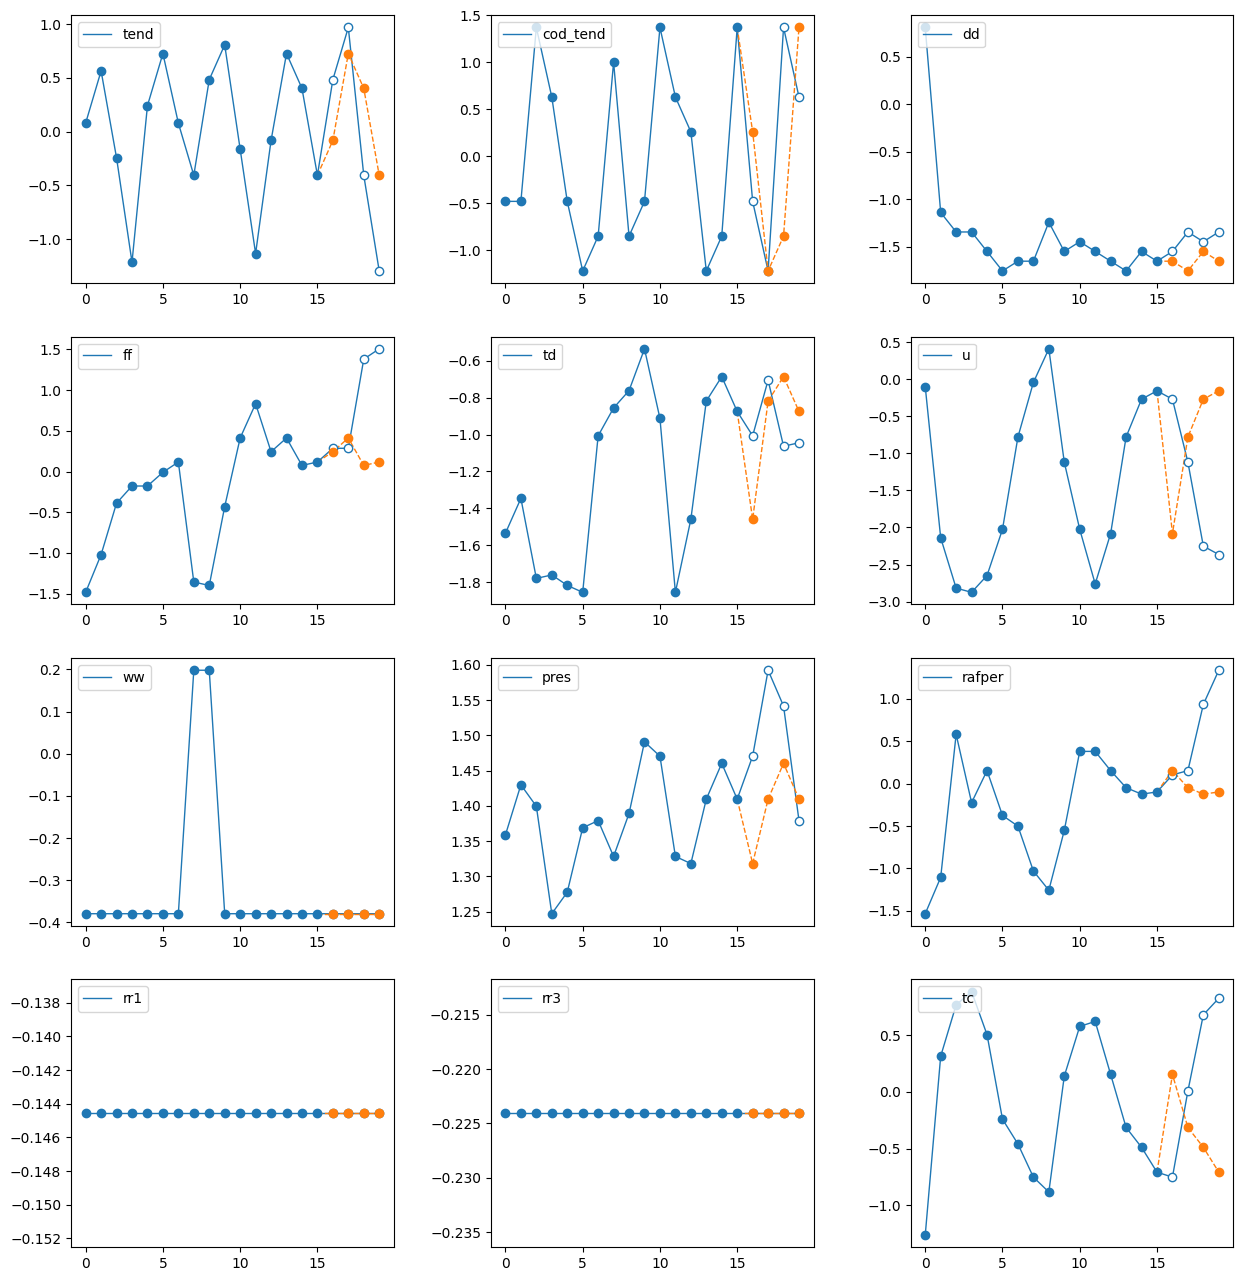

In [ ]:
plot_multivariate(sequence_true, predictions=pred, labels=features, save_as='01-prediction-norm')

In [ ]:
def get_prediction(dataset, model, iterations=4,sequence_len=16):

    # ---- Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = std_scaler.inverse_transform(sequence_true)
    pred          = std_scaler.inverse_transform(pred)

    return sequence_true,pred

In [ ]:
df_pred = pd.DataFrame(std_scaler.inverse_transform(pred), columns=features)
df_pred

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-80.0,8.0,100.0,3.8,272.55,74.0,0.0,101000.0,5.6,0.0,0.0,3.6
1,-170.0,8.0,100.0,5.1,274.55,46.0,0.0,100830.0,8.8,0.0,0.0,12.7
2,-220.0,8.0,100.0,6.9,275.05,35.0,0.0,100610.0,11.0,0.0,0.0,17.6
3,-200.0,8.0,150.0,6.2,275.65,34.0,0.0,100410.0,12.1,0.0,0.0,18.7


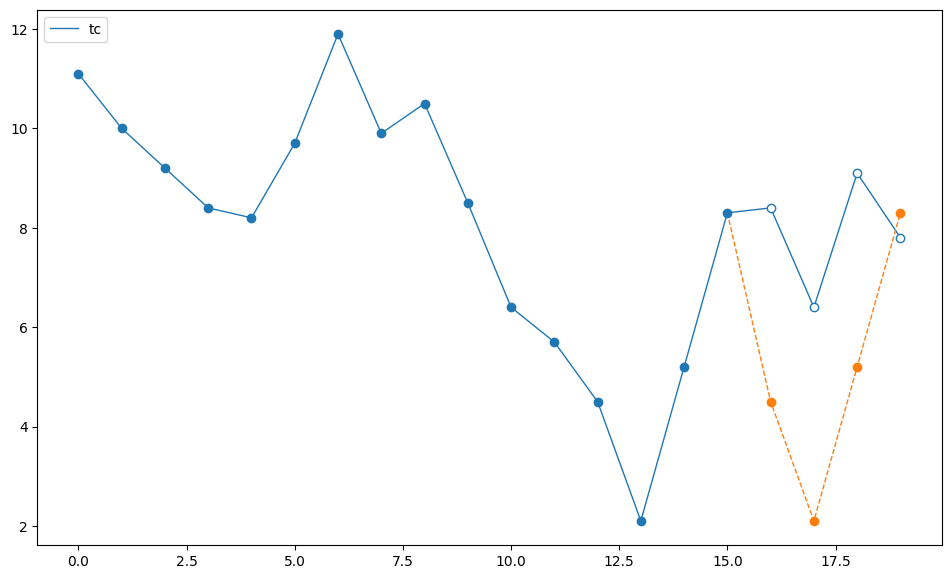

In [ ]:
feature = 11
sequence_true = std_scaler.inverse_transform(sequence_true)
pred = std_scaler.inverse_transform(pred)

plot_multivariate(sequence_true, predictions=pred, labels=features,
                            only_features=[feature],width=14, height=8, save_as='02-prediction')